In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [2]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

traindata = train_datagen.flow_from_directory(
    directory="/content/drive/MyDrive/Cars/dataset",
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='training') # set as training data

testdata = train_datagen.flow_from_directory(
    directory="/content/drive/MyDrive/Cars/dataset", # same directory as training data
    target_size=(224, 224),
    batch_size=4,
    class_mode='binary',
    subset='validation')

Found 518 images belonging to 2 classes.
Found 129 images belonging to 2 classes.


In [18]:
baseModel = VGG16(weights='imagenet', include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


headModel = baseModel.output
headModel = AveragePooling2D((2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)


for layer in baseModel.layers:
	layer.trainable = False

INIT_LR = 1e-2  # =0.0001
EPOCHS = 10
BS = 10

# compile our model
print("[INFO] compiling model...")
opt = Adam()
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")

model.summary()

#create callback
filepath = 'best_model.h5.keras'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
Callbacks = [checkpoint]

history = model.fit(traindata,validation_data = testdata,
                         steps_per_epoch = 100,validation_steps = 10,
                         epochs = EPOCHS,callbacks=Callbacks)

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("final_model.weights.h5")
print("Saved model to disk")

[INFO] compiling model...
[INFO] training head...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 3, 3, 512)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 19,435,329 (74.14 MB)

 Trainable params: 4,720,641 (18.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_164']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


 33/100 ━━━━━━━━━━━━━━━━━━━━ 19s 295ms/step - accuracy: 0.6217 - loss: 1.2272
Epoch 1: val_loss improved from inf to 0.34215, saving model to best_model.h5.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.6941 - loss: 0.9290 - val_accuracy: 0.8250 - val_loss: 0.3422
Epoch 2/10
 33/100 ━━━━━━━━━━━━━━━━━━━━ 20s 299ms/step - accuracy: 0.8830 - loss: 0.2230
Epoch 2: val_loss improved from 0.34215 to 0.22249, saving model to best_model.h5.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.8889 - loss: 0.2252 - val_accuracy: 0.8500 - val_loss: 0.2225
Epoch 3/10
 33/100 ━━━━━━━━━━━━━━━━━━━━ 18s 282ms/step - accuracy: 0.9299 - loss: 0.1614
Epoch 3: val_loss improved from 0.22249 to 0.21242, saving model to best_model.h5.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.9394 - loss: 0.1455 - val_accuracy: 0.9250 - val_loss: 0.2124
Epoch 4/10
 33/100 ━━━━━━━━━━━━━━━━━━━━ 20s 303ms/step - accuracy: 0.9706 - loss: 0.0996
Epoch 4: val_loss improved from 0.2

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


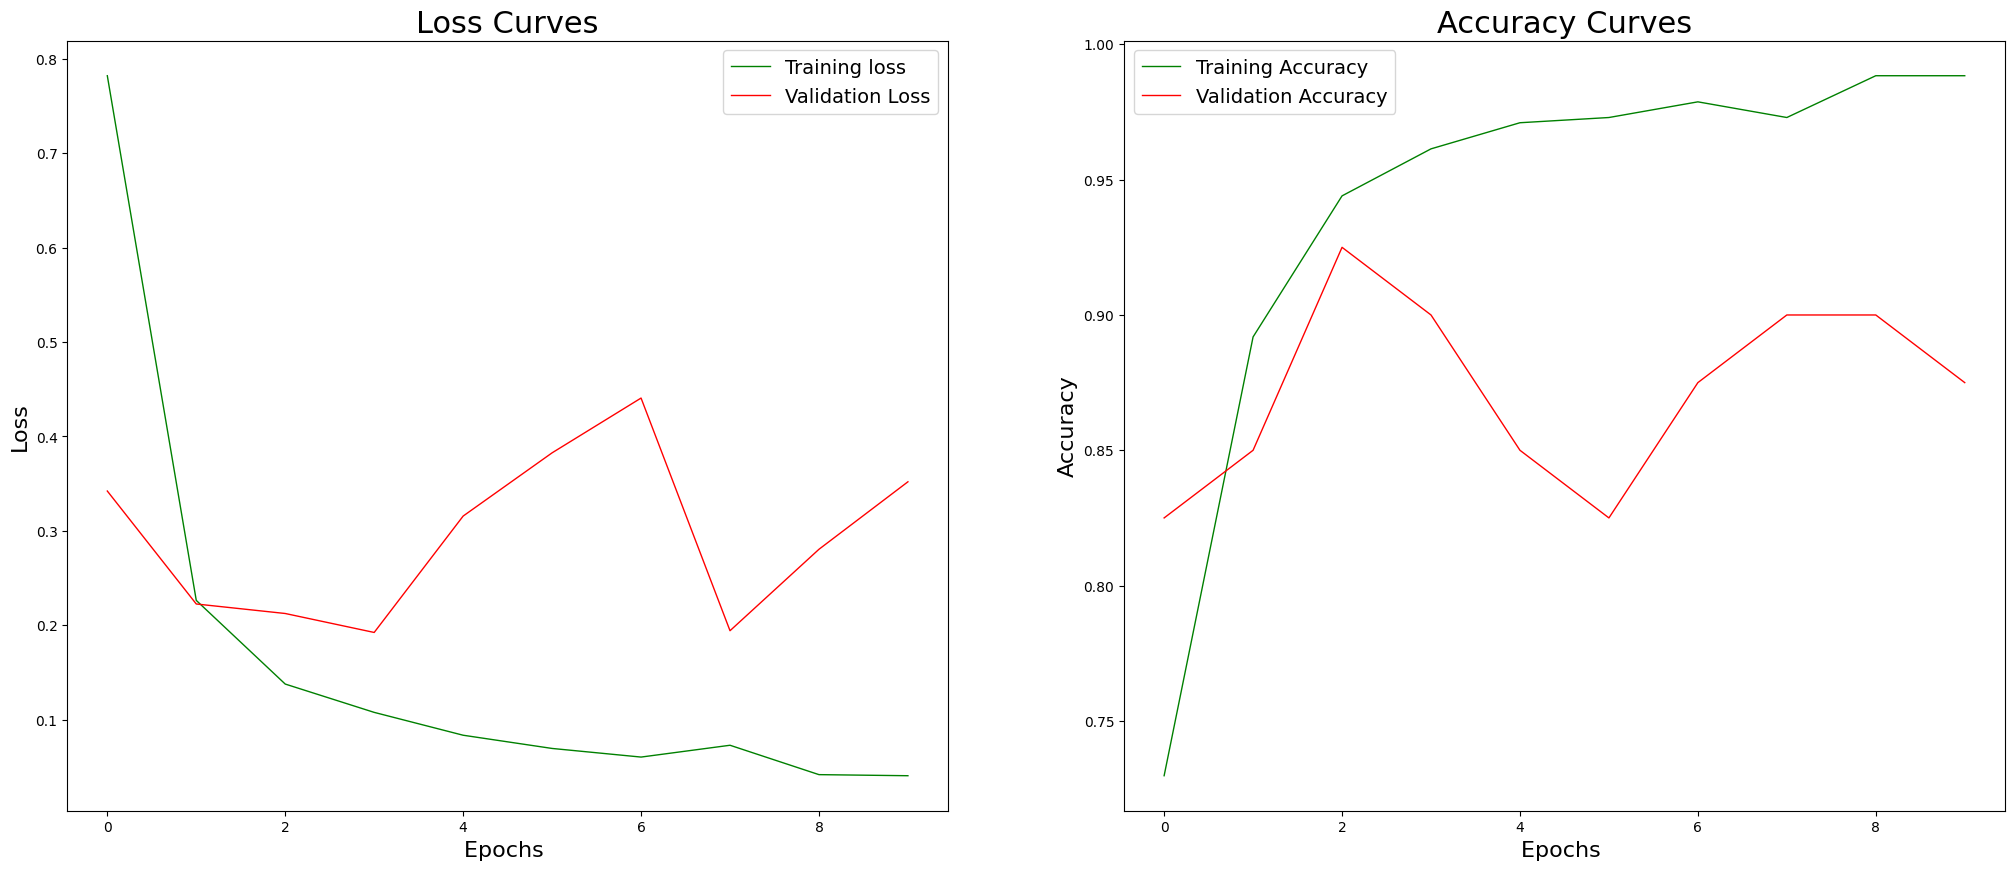

In [19]:
print(history.history.keys())

# Loss Curves
plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'],'-g',linewidth=1.0)
plt.plot(history.history['val_loss'],'r',linewidth=1.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=22)

# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'],'-g',linewidth=1.0)
plt.plot(history.history['val_accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=14)
plt.xlabel('Epochs ',fontsize=16)

plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=22)
plt.show()

In [20]:
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image
import h5py
import cv2
from PIL import Image

In [21]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("best_model.h5.keras")
print("Loaded model from disk")

Loaded model from disk


In [22]:
classnames = ['ferrari','honda']

In [30]:
img = cv2.imread("/content/drive/MyDrive/Cars/dataset/Ferrari/008185.jpg")

img = cv2.resize(img,(224,224))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img)
img_pred = image.img_to_array(im_pil)
img_pred = np.expand_dims(img_pred, axis = 0)
rslt = loaded_model.predict(img_pred)
A = np.array(rslt[0])
maximum_indices = np.where(A==max(rslt[0]))
pred = str(classnames[int(maximum_indices[0][0])])
print (pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
ferrari
